# Convolutional Autoencoder

In [22]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

import autoencoder

In [2]:
%load_ext autoreload
%autoreload 2

## Data

Noisy (added Gaussian noise) MNIST images.

In [7]:
MNIST_data = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


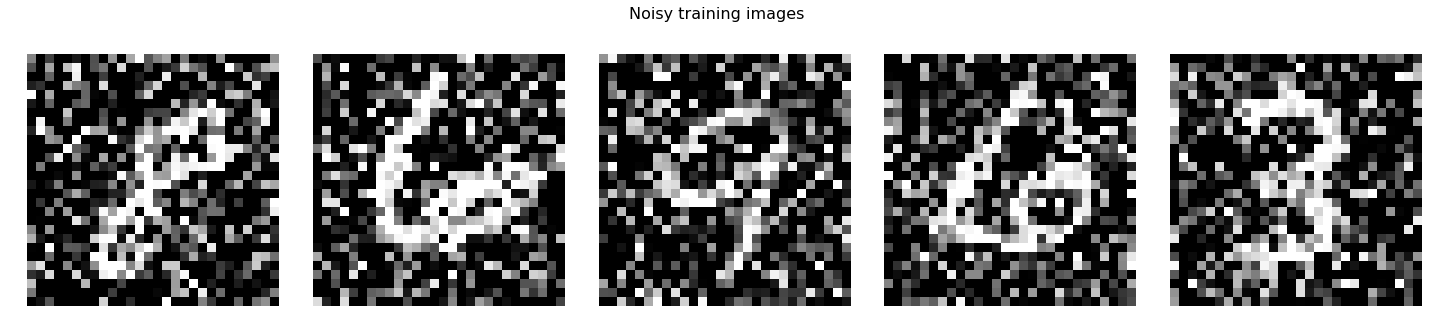

In [27]:
noise_strength = 0.5

images = MNIST_data.train.images[:5]
noisy = images + noise_strength * np.random.randn(*images.shape)
noisy = np.clip(noisy, 0, 1)

fig, ax = plt.subplots(figsize=(20, 5), ncols=len(noisy))
plt.suptitle('Noisy training images', fontsize=16)

for i in range(len(noisy)):
    ax[i].imshow(noisy[i].reshape(28, 28), cmap='Greys_r')
    ax[i].axis('off')
    
plt.tight_layout()
plt.show();

## Training

View graph with `tensorboard --logdir="logs"` @ http://127.0.0.1:6006/

In [5]:
MNIST_autoencoder = autoencoder.buil_MNIST_autoencoder()

In [17]:
epochs = 100
batch_size = 256
num_training_batches = MNIST_data.train.num_examples // batch_size

session = tf.Session()
session.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('logs', session.graph) 

with tqdm(total=epochs * num_training_batches) as pbar:
    for e in range(epochs):
        for i in range(num_training_batches):
            batch = MNIST_data.train.next_batch(batch_size)
            mnist_images = batch[0].reshape((batch_size, 28, 28, 1))
            noisy_images = mnist_images + noise_strength * np.random.randn(*mnist_images.shape)
            noisy_images = np.clip(noisy_images, 0, 1)

            loss, _ = session.run(
                [
                    MNIST_autoencoder['cost_function'], 
                    MNIST_autoencoder['optimiser']
                ],
                feed_dict={
                    MNIST_autoencoder['model_input']: noisy_images,
                    MNIST_autoencoder['model_targets']: mnist_images
                }
            )

            pbar.set_description('Training Loss: %.3f' % loss)
            pbar.update(1)

writer.close()

Training Loss: 0.099: 100%|██████████| 23400/23400 [12:08<00:00, 32.18it/s]


## Test

In [18]:
num_test_batches = MNIST_data.test.num_examples // batch_size
total_loss = 0
    
with tqdm(total=num_test_batches) as pbar:
    for i in range(num_test_batches):
        batch = MNIST_data.test.next_batch(batch_size)
        mnist_images = batch[0].reshape((batch_size, 28, 28, 1))
        noisy_images = mnist_images + noise_strength * np.random.randn(*mnist_images.shape)
        noisy_images = np.clip(noisy_images, 0, 1)

        loss, _ = session.run(
            [
                MNIST_autoencoder['cost_function'], 
                MNIST_autoencoder['optimiser']
            ],
            feed_dict={
                MNIST_autoencoder['model_input']: noisy_images,
                MNIST_autoencoder['model_targets']: mnist_images
            }
        )

        total_loss += loss

        pbar.set_description('Testing...')
        pbar.update(1)

    pbar.set_description('Testing Loss: %.3f' % (total_loss / num_test_batches))

Testing Loss: 0.100: 100%|██████████| 39/39 [00:01<00:00, 32.61it/s]


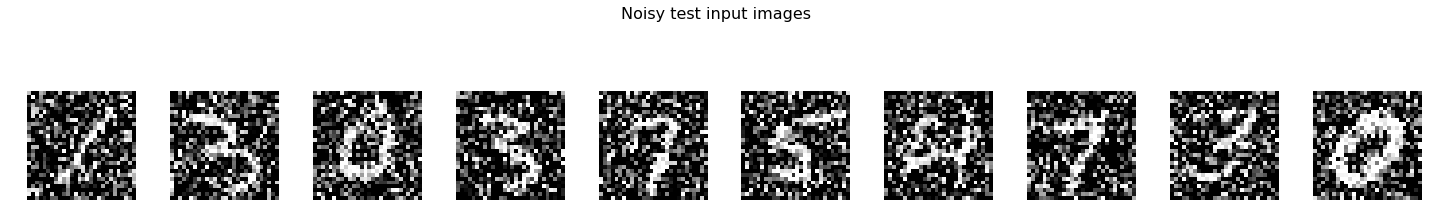

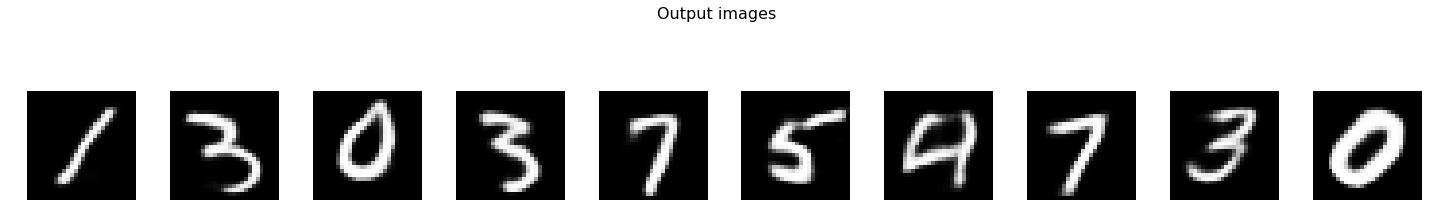

In [26]:
images = MNIST_data.test.images[:10]
noisy_images = images + noise_strength * np.random.randn(*images.shape)
noisy_images = np.clip(noisy_images, 0, 1)

fig, ax = plt.subplots(figsize=(20, 4), ncols=len(noisy_images))
plt.suptitle('Noisy test input images', fontsize=16)
for i in range(len(noisy_images)):
    ax[i].imshow(noisy_images[i].reshape(28, 28), cmap='Greys_r')
    ax[i].axis('off')
plt.tight_layout()
plt.show();

output = session.run(
    MNIST_autoencoder['decoder'],
    feed_dict={
        MNIST_autoencoder['model_input']: noisy_images.reshape(10, 28, 28, 1),
    }
)

fig, ax = plt.subplots(figsize=(20, 4), ncols=len(output))
plt.suptitle('Output images', fontsize=16)
for i in range(len(output)):
    ax[i].imshow(output[i].reshape(28, 28), cmap='Greys_r')
    ax[i].axis('off')
plt.tight_layout()
plt.show();